In [ ]:
!pip install requests beautifulsoup4 nltk pandas tqdm scikit-learn transformers torch spacy simalign pandas numpy matplotlib

!pip install indic-nlp-library

!python3 -m spacy download xx_ent_wiki_sm

!python3 -m spacy download en_core_web_sm


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 15.2 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 19.2 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
###############################################################################
# FULL SCRIPT  – single-pass crawl + multi-threshold export
###############################################################################

import nltk
nltk.download('punkt')

import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import torch
import spacy
import logging
import numpy as np
from simalign import SentenceAligner
from indicnlp.tokenize import sentence_tokenize
from indicnlp import common
import json
import os
import time
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# ------------------------------------------------------------------ #
#  Polite, retry-aware HTTP session for the Wikimedia API
# ------------------------------------------------------------------ #
session = requests.Session()
session.headers.update({
    "User-Agent": "WikiMiner/1.0 (sample_email@gmail.com)"  # <-- put real email
})
retry = Retry(
    total=5,                # up to 5 retries
    backoff_factor=1.5,     # sleep: 1.5s, 3s, 4.5s, ...
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET"]
)
session.mount("https://", HTTPAdapter(max_retries=retry))
session.mount("http://",  HTTPAdapter(max_retries=retry))
# ------------------------------------------------------------------ #

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

###############################################################################
#                              CONFIGURATION
###############################################################################

INDIC_LANGUAGES = [
    'as', 'bn', 'gu', 'hi', 'kn', 'ml', 'mr', 'or', 'pa', 'ta', 'te',
]

LANG_CODE_MAP = {
    'as': 'Assamese', 'bn': 'Bengali', 'gu': 'Gujarati', 'hi': 'Hindi',
    'kn': 'Kannada',  'ml': 'Malayalam', 'mr': 'Marathi', 'or': 'Oriya',
    'pa': 'Punjabi',  'ta': 'Tamil',     'te': 'Telugu',
}

# Define categories to crawl in English, which (hopefully) contain articles relevant
# to each language. You can customize or expand these categories as needed.
language_categories = {
    'as': [
        "Articles containing Assamese-language text",
        "Assamese-language actors",
        "People from Assam",
        "Assam Valley Literary Award",
        "Assamese singers",
        "Novels in Assamese",
        "CS1 Assamese-language sources (as)",
        "Assamese-language film stubs",
        "Assamese-language mass media",
        "Assamese people",
        "Assamese nationalism",
        # Newly added categories for Assamese
        "Assamese literature",
        "Cinema of Assam",
        "Music of Assam",
        "Festivals in Assam",
        "Assamese cuisine",
        "Assamese folklore & mythology",
        "Dances and theatre of Assam",
        "Assamese-language media",
        "Notable Assamese people",
        "Awards and honors in Assam",
    ],
    'bn': [
        "Bengali-language films",
        "Bengali people",
        "Bengali-language writers",
        "Bengali words and phrases",
        "Bengali language",
        "Articles containing Bengali-language text",
        "Bengali poetry in English translation",
        "Songs in Bengali",
        "Bengali nationalism",
        "Bengali-language surnames",
        # Newly added categories for Bengali
        "Bengali literature",
        "Bengali cinema",
        "Bengali music and songs",
        "Festivals of Bengal",
        "Bengali cuisine",
        "Bengali mythology & folk tales",
        "Bengali theatre and dance",
        "Notable Bengali people",
        "Literary awards in Bengali",
        "Bengali media",
    ],
    'gu': [
        "Gujarati people",
        "Gujarati writers",
        "Articles containing Gujarati-language text",
        "Gujarati literature",
        "Gujarati-language films",
        "Gujarati-language books",
        "Gujarati-language writers",
        "Gujarati language",
        "Articles with Gujarati-language sources (gu)",
        "Gujarati-language songs",
        # Newly added categories for Gujarati
        "Gujarati cinema",
        "Gujarati music",
        "Festivals in Gujarat",
        "Gujarati cuisine",
        "Gujarati folklore & mythology",
        "Gujarati theatre (Bhavai)",
        "Gujarati media",
        "Notable Gujarati people",
        "Cultural institutions & awards",
    ],
    'hi': [
        "Hindi",
        "Hindi-language films",
        "Actors in Hindi cinema",
        "Hindi-language literature",
        "Hindi-language film directors",
        "Hindi-language writers",
        "Articles containing Hindi-language text",
        "Hindi theatre",
        "Hindi-language poets",
        # Newly added categories for Hindi
        "Hindi literature",
        "Hindi cinema (Bollywood)",
        "Hindi music and songs",
        "Indian festivals (North India)",
        "Hindu epics and mythology",
        "Hindi media",
        "Notable Hindi authors and poets",
        "Hindi theatre and folk arts",
        "National awards (Hindi context)",
        "Historical events (Hindi belt)",
    ],
    'kn': [
        "Kannada-language films",
        "Kannada poets",
        "Kannada playback singers",
        "Kannada film directors",
        "Kannada literature",
        "Kannada cinema",
        "Kannada grammar",
        "Kannada-language writers",
        "Articles containing Kannada-language text",
        "Kannada people",
        # Newly added categories for Kannada
        "Kannada music",
        "Festivals of Karnataka",
        "Kannada cuisine",
        "Kannada folklore & mythology",
        "Kannada theater and dance",
        "Notable Kannada people",
        "Awards in Kannada",
        "Kannada media",
    ],
    'ml': [
        "Malayalam-language films",
        "Malayalam cinema",
        "Articles containing Malayalam-language text",
        "Malayalam poets",
        "Malayalam-language writers",
        "Malayalam grammar",
        "Malayalam-language newspapers",
        "Malayalam language",
        "Malayalam-language novelists",
        # Newly added categories for Malayalam
        "Malayalam literature",
        "Malayalam music",
        "Festivals of Kerala",
        "Malayalam cuisine",
        "Kerala folklore & mythology",
        "Malayalam theatre and dance",
        "Notable Malayalam people",
        "Malayalam media",
        "Kerala history events",
    ],
    'mr': [
        "Marathi language",
        "Marathi people",
        "Marathi-language films",
        "Actors in Marathi theatre",
        "Marathi-language writers",
        "Articles containing Marathi-language text",
        "Marathi terms",
        "Marathi-language literature",
        "Marathi-language poets",
        # Newly added categories for Marathi
        "Marathi literature",
        "Marathi cinema",
        "Marathi music",
        "Festivals in Maharashtra",
        "Marathi cuisine",
        "Marathi mythology & Bhakti saints",
        "Marathi theatre (Sangeet Natak)",
        "Notable Marathi people",
        "Marathi media",
        "Awards in Marathi",
    ],
    'or': [
        "Odia language",
        "Articles containing Odia-language text",
        "Odia-language writers",
        "Odia cuisine",
        "Actors in Odia cinema",
        "Odia literature",
        "Odia people",
        "Odia-language films",
        "Odia-language actors",
        "Odia Hindu saints",
        # Newly added categories for Odia
        "Odia music",
        "Festivals of Odisha",
        "Odisha folklore & mythology",
        "Odissi dance and arts",
        "Notable Odia people",
        "Odia media",
        "Odisha awards and organizations",
    ],
    'pa': [
        "Punjabi festivals",
        "Punjabi language",
        "Punjabi people",
        "Punjabi dialects",
        "Punjabi words and phrases",
        "Punjabi music",
        "Punjabi-language films",
        "Punjabi-language writers",
        "Punjabi-language singers",
        "Articles containing Punjabi-language text",
        "Punjabi-language surnames",
        # Newly added categories for Punjabi
        "Punjabi literature",
        "Punjabi cinema",
        "Festivals of Punjab",
        "Punjabi cuisine",
        "Sikh mythology and history",
        "Punjabi folk culture",
        "Notable Punjabi people",
        "Punjabi media",
        "Punjab region history events",
    ],
    'ta': [
        "Tamil",
        "Tamil people",
        "Tamil-language films",
        "Tamil film directors",
        "Tamil diaspora",
        "Tamil film producers",
        "Tamil writers",
        "Articles containing Tamil-language text",
        "Tamil architecture",
        "People from Tamil Nadu",
        "Tamil scholars",
        # Newly added categories for Tamil
        "Tamil literature",
        "Tamil cinema",
        "Tamil music and songs",
        "Tamil festivals",
        "Tamil cuisine",
        "Tamil mythology and religion",
        "Tamil dynasties and history",
        "Notable Tamil people",
        "Tamil media",
        "Tamil theatre and arts",
    ],
    'te': [
        "Telugu people",
        "Telugu-language films",
        "Telugu actors",
        "Telugu cinema",
        "Telugu film directors",
        "Telugu language",
        "Articles containing Telugu-language text",
        "Telugu writers",
        "Telugu poets",
        "Telugu names",
        # Newly added categories for Telugu
        "Telugu literature",
        "Telugu music",
        "Festivals in Andhra/Telangana",
        "Telugu cuisine",
        "Telugu mythology & religion",
        "Telugu theater",
        "Notable Telugu people",
        "Telugu media",
        "Awards in Telugu",
    ],
}

# Path to the root directory of the Indic NLP resources
INDIC_RESOURCES_PATH = 'D:/indic_nlp_resources-master/indic_nlp_resources-master'
common.set_resources_path(INDIC_RESOURCES_PATH)

SIM_THRESHOLDS   = [0.6, 0.7, 0.8]            # τ  – cosine similarity
ALIGN_THRESHOLDS = [0.4, 0.5, 0.6, 0.7, 0.8]  # α  – word-alignment ratio

###############################################################################
#                              LOAD MODELS
###############################################################################

logging.info("Loading multilingual transformer model (LaBSE)...")
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE')
model     = AutoModel.from_pretrained('sentence-transformers/LaBSE')
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
logging.info(f"Transformer model loaded on device: {device}")

logging.info("Loading SpaCy models...")
try:
    nlp_en = spacy.load('en_core_web_sm')
except Exception as e:
    logging.error(f"Error loading SpaCy English model: {e}")

if "sentencizer" not in nlp_en.pipe_names:
    logging.info("Adding 'sentencizer' to SpaCy English pipeline.")
    nlp_en.add_pipe("sentencizer", first=True)

aligner = SentenceAligner(model="bert", token_type="bpe", matching_methods="mai")

###############################################################################
#                              HELPER FUNCTIONS
###############################################################################

def get_articles_in_category(category_title, lang):
    """
    Fetches all article titles under a Wikipedia category.
    """
    url = f'https://{lang}.wikipedia.org/w/api.php'
    params = {
        'action': 'query',
        'list': 'categorymembers',
        'cmtitle': f'Category:{category_title}',
        'cmlimit': 'max',
        'format': 'json',
    }
    articles = []
    while True:
        try:
            response = session.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            for page in data['query']['categorymembers']:
                if page['ns'] == 0:
                    articles.append(page['title'])
            if 'continue' in data:
                params['cmcontinue'] = data['continue']['cmcontinue']
            else:
                break
        except requests.exceptions.RequestException as e:
            logging.error(f"Request failed for category '{category_title}' in '{lang}': {e}")
            break
    return articles

def get_langlinks(title, source_lang, target_lang):
    """
    Checks if an article in source_lang has an equivalent article in target_lang.
    Returns the title in target_lang if exists, else None.
    """
    url = f'https://{source_lang}.wikipedia.org/w/api.php'
    params = {
        'action': 'query',
        'titles': title,
        'prop': 'langlinks',
        'lllang': target_lang,
        'format': 'json',
    }
    try:
        response = session.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        pages = data['query']['pages']
        for page_id in pages:
            if 'langlinks' in pages[page_id]:
                return pages[page_id]['langlinks'][0]['*']
    except requests.exceptions.RequestException as e:
        logging.error(f"Request failed for langlinks of page '{title}' from '{source_lang}' to '{target_lang}': {e}")
    return None

def get_wikipedia_page(title, lang):
    """
    Fetches the Wikipedia page content for a given title and language.
    """
    url = f'https://{lang}.wikipedia.org/w/api.php'
    params = {
        'action': 'parse',
        'page': title,
        'prop': 'text',
        'format': 'json',
        'redirects': True,
    }
    try:
        response = session.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if 'error' in data:
            logging.warning(f"Error fetching page '{title}' in '{lang}': {data['error']['info']}")
            return None
        return data['parse']['text']['*']
    except requests.exceptions.RequestException as e:
        logging.error(f"Request failed for page '{title}' in '{lang}': {e}")
        return None

def extract_text(html_content):
    """
    Extracts and cleans text from HTML content.
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    for element in soup(['table', 'sup', 'span', 'ol', 'ul', 'style', 'script']):
        element.decompose()
    text = soup.get_text(separator=' ')
    text = re.sub(r'\[\d+\]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def split_into_sentences(text, lang):
    """
    Splits text into sentences using appropriate tokenizer based on language.
    """
    if lang == 'en':
        doc = nlp_en(text)
        return [sent.text.strip() for sent in doc.sents]
    else:
        return sentence_tokenize.sentence_split(text, lang)

def encode_sentences(sentences):
    """
    Encodes sentences into vectors using a multilingual transformer model.
    """
    embeddings = []
    batch_size = 32
    with torch.no_grad():
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
            outputs = model(**inputs)
            embeddings.append(outputs.pooler_output.cpu())
    return torch.cat(embeddings, dim=0) if embeddings else torch.tensor([])

def compute_similarity(embeddings_en, embeddings_target):
    """
    Computes cosine similarity between English and target language sentence embeddings.
    """
    if embeddings_en.size(0) == 0 or embeddings_target.size(0) == 0:
        logging.warning("One of the embedding sets is empty. Cannot compute similarity.")
        return None
    en_np = embeddings_en.numpy() / np.linalg.norm(embeddings_en.numpy(), axis=1, keepdims=True)
    tgt_np = embeddings_target.numpy() / np.linalg.norm(embeddings_target.numpy(), axis=1, keepdims=True)
    return cosine_similarity(en_np, tgt_np)

def align_sentences(sentences_en, sentences_target, sim_matrix, threshold=0.8, alignment_threshold=0.8):
    """
    Aligns sentences based on similarity scores with bidirectional best matching and filtering.
    Uses word alignment from SimAlign to check alignment quality.
    """
    aligned = []
    best_tgt = sim_matrix.argmax(axis=1)
    best_tgt_scores = sim_matrix.max(axis=1)
    best_en = sim_matrix.argmax(axis=0)
    best_en_scores = sim_matrix.max(axis=0)
    for i, j in enumerate(best_tgt):
        sim_score = best_tgt_scores[i]
        if sim_score < threshold: continue
        if best_en[j] != i or best_en_scores[j] < threshold: continue
        en_s, tgt_s = sentences_en[i], sentences_target[j]
        l_en, l_tgt = len(en_s.split()), len(tgt_s.split())
        if l_en == 0 or l_tgt == 0: continue
        if max(l_en, l_tgt)/min(l_en, l_tgt) > 1.3: continue
        aligns = aligner.get_word_aligns(en_s, tgt_s)
        align_count = len(aligns['inter'])
        align_score = align_count / min(l_en, l_tgt)
        if align_score >= alignment_threshold:
            aligned.append((en_s, tgt_s, align_score, float(sim_score)))
    return aligned

# ---------------------- length-&-coverage helpers --------------------- #
def sent_lengths(pair):
    """Return (len_en, len_tgt, ratio)."""
    l_en  = len(pair["en"].split())
    l_tgt = len(pair["tgt"].split())
    ratio = max(l_en, l_tgt) / min(l_en, l_tgt) if min(l_en, l_tgt) else 0
    return l_en, l_tgt, ratio

def token_coverage(pair):
    """aligned token count / English length"""
    l_en = len(pair["en"].split())
    return (pair["align"] * min(l_en, len(pair["tgt"].split()))) / l_en if l_en else 0
# --------------------------------------------------------------------- #

###############################################################################
#                              MAIN LOGIC
###############################################################################

def main(
    langs: list[str] | None = None,
    sim_thresholds: list[float] | None = None,
    alpha_thresholds: list[float] | None = None,
):
    if langs is None: langs = INDIC_LANGUAGES
    if sim_thresholds is None: sim_thresholds = SIM_THRESHOLDS
    if alpha_thresholds is None: alpha_thresholds = ALIGN_THRESHOLDS

    EN_LANG = 'en'

    for lang_code in langs:
        language_name = LANG_CODE_MAP.get(lang_code, lang_code)
        logging.info(f"==================== {language_name} ({lang_code}) "
                     "====================")

        all_pairs = []
        article_category = {}

        categories = language_categories.get(lang_code, [])
        if not categories:
            logging.warning(f"No categories specified for {language_name}. Skipping.")
            continue

        # 1. COLLECT ARTICLE TITLES
        article_titles = set()
        for cat in categories:
            titles_en = get_articles_in_category(cat, EN_LANG)
            for t in titles_en:
                article_category.setdefault(t, cat)
            article_titles.update(titles_en)
        logging.info(f"Found {len(article_titles)} unique English articles.")

        # 2. PROCESS EACH BILINGUAL ARTICLE
        titles_with_langlinks = 0
        for title in tqdm(article_titles, desc=f"Langlinks > {language_name}", leave=False):
            tgt_title = get_langlinks(title, EN_LANG, lang_code)
            if tgt_title is None: continue
            titles_with_langlinks += 1

            html_en = get_wikipedia_page(title, EN_LANG)
            html_tgt = get_wikipedia_page(tgt_title, lang_code)
            if not html_en or not html_tgt: continue

            text_en = extract_text(html_en)
            text_tgt = extract_text(html_tgt)
            if not text_en or not text_tgt: continue

            def filter_sents(sents, lo=5, hi=200):
                return [s for s in sents if lo <= len(s.split()) <= hi]

            sents_en = filter_sents(split_into_sentences(text_en, EN_LANG))
            sents_tgt = filter_sents(split_into_sentences(text_tgt, lang_code))
            if not sents_en or not sents_tgt: continue

            emb_en = encode_sentences(sents_en)
            emb_tgt = encode_sentences(sents_tgt)
            sim_mtx = compute_similarity(emb_en, emb_tgt)
            if sim_mtx is None: continue

            aligned_raw = align_sentences(sents_en, sents_tgt, sim_mtx,
                                          threshold=0.4, alignment_threshold=0.0)
            cat = article_category[title]
            for en_s, tgt_s, align_sc, sim_sc in aligned_raw:
                all_pairs.append({
                    "en": en_s,
                    "tgt": tgt_s,
                    "sim": sim_sc,
                    "align": align_sc,
                    "category": cat
                })

        logging.info(f"{titles_with_langlinks}/{len(article_titles)} articles had {language_name} counterparts.")
        logging.info(f"Total raw sentence pairs harvested: {len(all_pairs)}")

        # 3. MULTI-THRESHOLD OUTPUT LOOP
        for tau in sim_thresholds:
            for alpha in alpha_thresholds:
                ds_dir = os.path.join("parallel_datasets_2", str(tau), str(alpha))
                st_dir = os.path.join("stats_2", str(tau), str(alpha))
                os.makedirs(ds_dir, exist_ok=True)
                os.makedirs(st_dir, exist_ok=True)

                selected = [p for p in all_pairs if p["sim"] >= tau and p["align"] >= alpha]

                # ---------- PARALLEL DATASET JSONL --------------------------
                df = pd.DataFrame([(p["en"], p["tgt"]) for p in selected],
                                  columns=["English", language_name])
                ds_path = os.path.join(ds_dir, f"parallel_dataset_2_{language_name.lower()}.json")
                df.to_json(ds_path, orient="records", lines=True, force_ascii=False)

                # ---------- STATS (aggregate + per-category) ---------------
                if selected:
                    en_lens, tgt_lens, ratios = zip(*(sent_lengths(p) for p in selected))
                    coverages = [token_coverage(p) for p in selected]
                    avg_en_len = float(np.mean(en_lens))
                    avg_tgt_len = float(np.mean(tgt_lens))
                    avg_len_ratio = float(np.mean(ratios))
                    avg_tok_coverage = float(np.mean(coverages))
                else:
                    avg_en_len = avg_tgt_len = avg_len_ratio = avg_tok_coverage = 0.0

                agg = {
                    "language": language_name,
                    "tau": tau,
                    "alpha": alpha,
                    "num_pairs": len(selected),
                    "mean_cosine": float(np.mean([p["sim"] for p in selected])) if selected else 0.0,
                    "mean_alignment": float(np.mean([p["align"] for p in selected])) if selected else 0.0,
                    "avg_en_len": avg_en_len,
                    "avg_tgt_len": avg_tgt_len,
                    "avg_len_ratio": avg_len_ratio,
                    "avg_token_coverage": avg_tok_coverage
                }

                by_cat = {}
                for cat in categories:
                    cp = [p for p in selected if p["category"] == cat]
                    if cp:
                        en_lens, tgt_lens, ratios = zip(*(sent_lengths(p) for p in cp))
                        coverages = [token_coverage(p) for p in cp]
                        by_cat[cat] = {
                            "num_pairs": len(cp),
                            "mean_cosine": float(np.mean([p["sim"] for p in cp])),
                            "mean_alignment": float(np.mean([p["align"] for p in cp])),
                            "avg_en_len": float(np.mean(en_lens)),
                            "avg_tgt_len": float(np.mean(tgt_lens)),
                            "avg_len_ratio": float(np.mean(ratios)),
                            "avg_token_coverage": float(np.mean(coverages))
                        }

                st_path = os.path.join(st_dir, f"stats_2_{language_name.lower()}.json")
                with open(st_path, "w", encoding="utf-8") as f:
                    json.dump({"aggregate": agg, "by_category": by_cat},
                              f, ensure_ascii=False, indent=4)

                logging.info(f"[{language_name}] τ={tau} α={alpha} → {len(selected)} pairs (saved: {ds_path})")

# --------------------------------------------------------------------------- #
if __name__ == "__main__":
    main()


[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-05-03 00:33:04,493 - INFO - Loading multilingual transformer model (LaBSE)...
2025-05-03 00:33:07,268 - INFO - Transformer model loaded on device: cuda
2025-05-03 00:33:07,270 - INFO - Loading SpaCy models...
2025-05-03 00:33:07,802 - INFO - Adding 'sentencizer' to SpaCy English pipeline.
2025-05-03 00:33:09,124 - simalign.simalign - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased
2025-05-03 00:33:09,124 - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased
2025-05-03 00:33:09,156 - INFO - ==================== Assamese (as) ====================
2025-05-03 00:33:17,101 - INFO - Found 702 unique English articles.
2025-05-03 01:20:55,254 - INFO - 433/702 articles had Assamese counterparts.    
2025-05-03 01:20:55,255 - INFO - Total raw sentence pairs harvested: 2362
2025-05-03 01:20:55,301 - INFO - [Assamese] τ

/tmp/ipykernel_56727/2221700195.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.85,0.96])


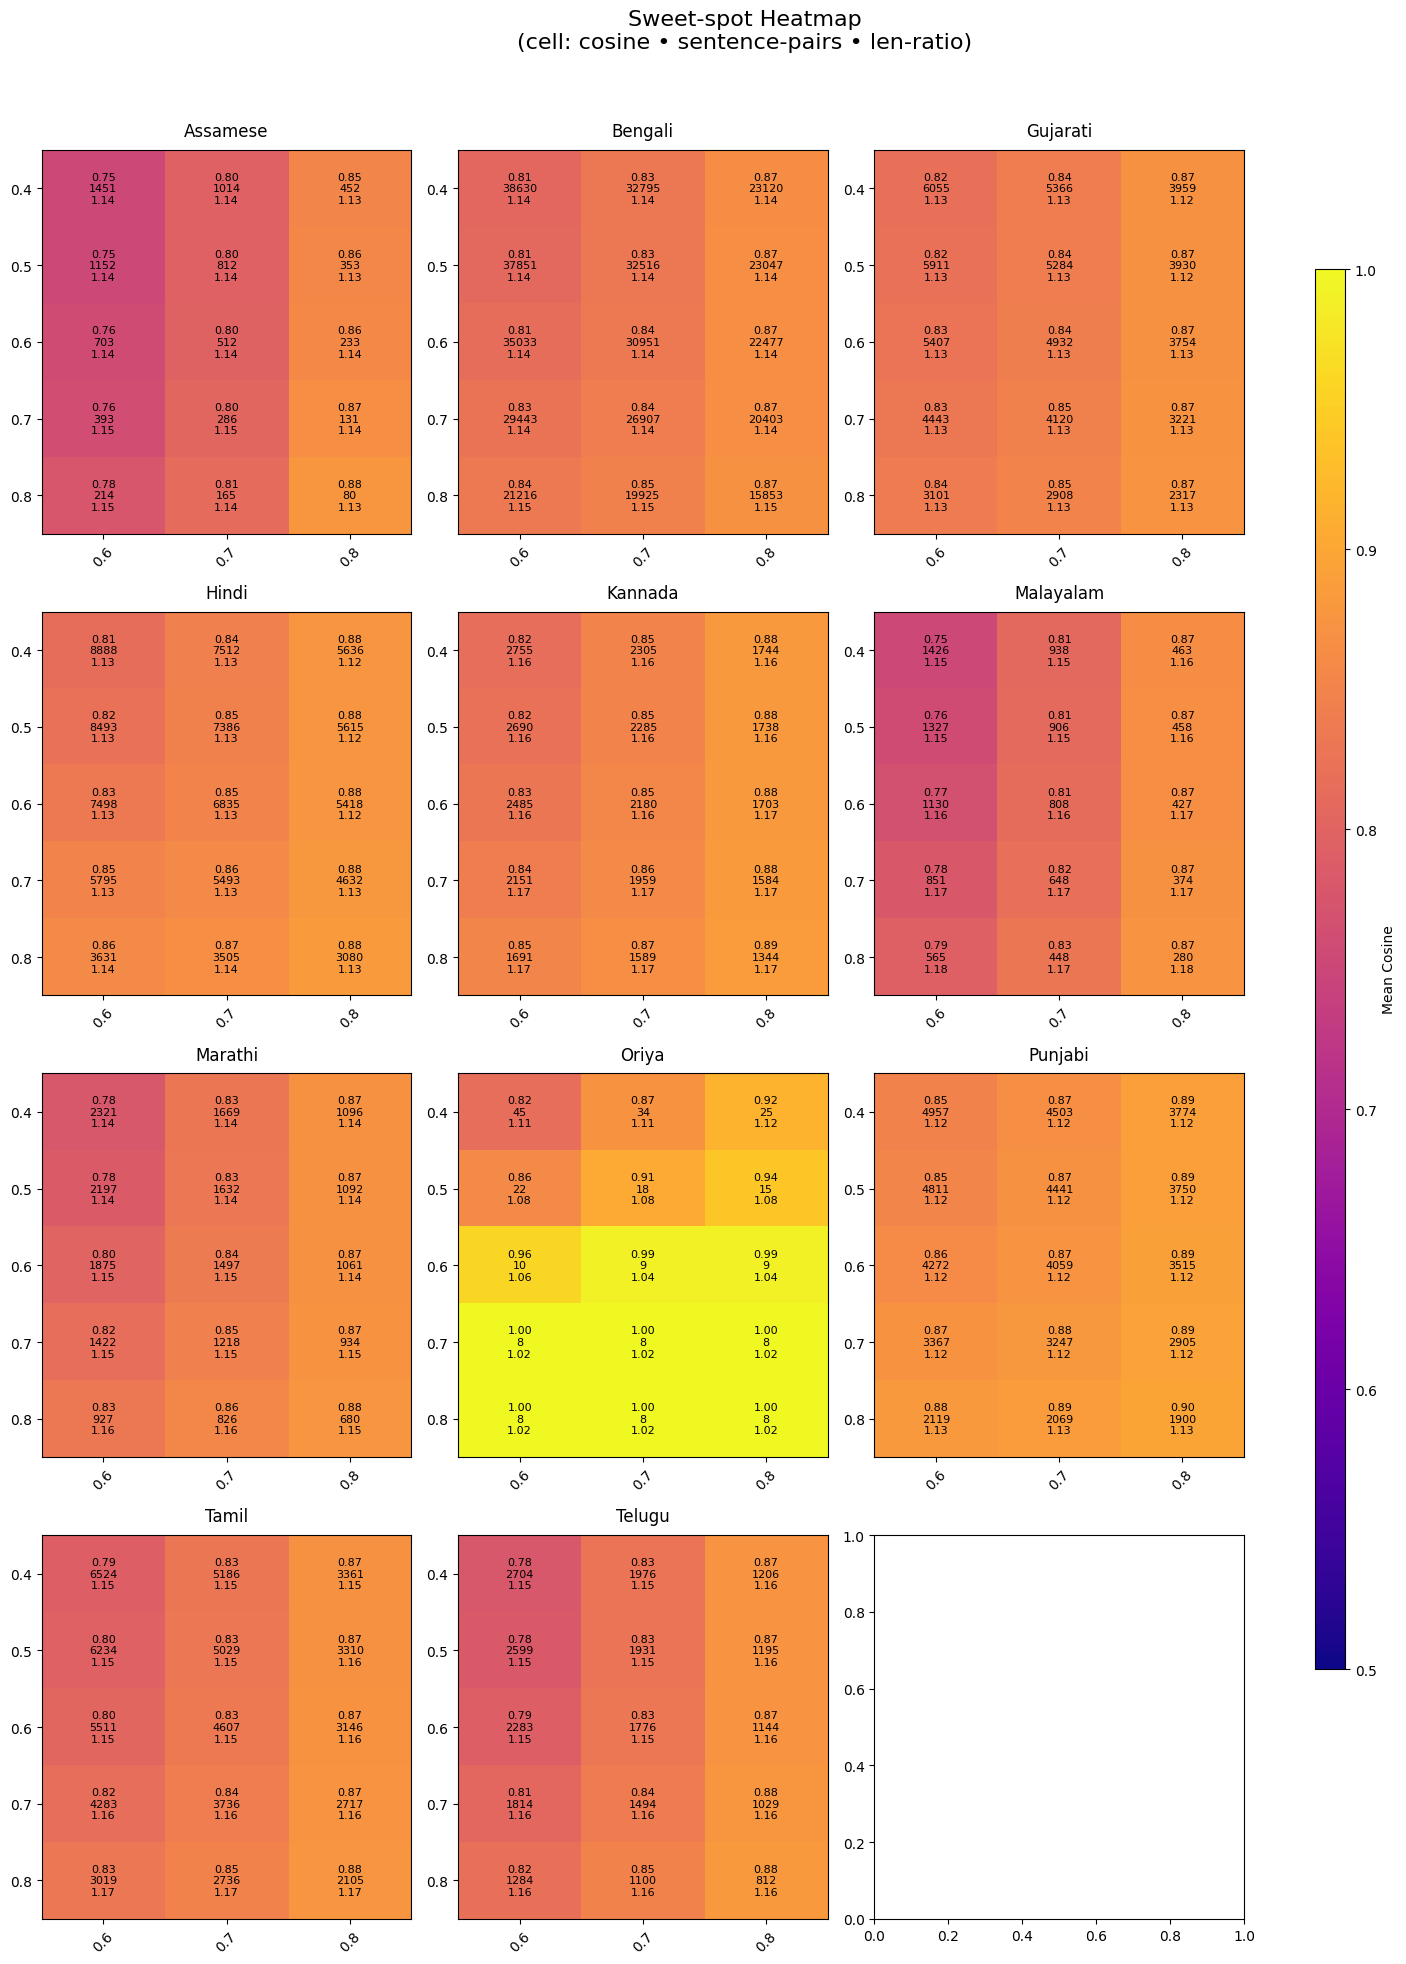

  • saved report_exports/20250505_143850/sweet_spot_01.png
💾  Multi‑page PDF written to  report_exports/20250505_143850/sweet_spot.pdf


<Figure size 640x480 with 0 Axes>

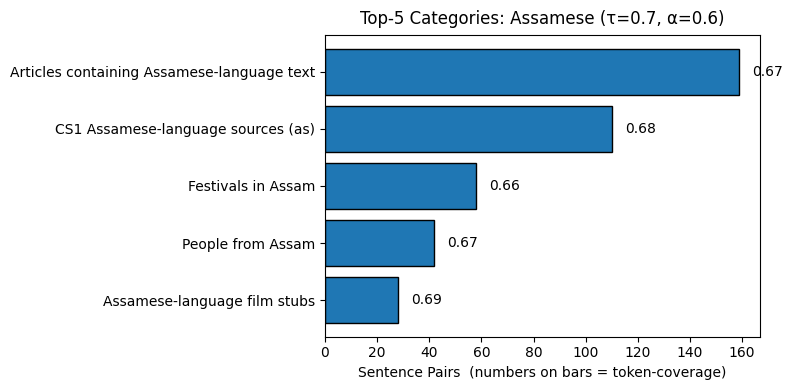

  • saved report_exports/20250505_143850/category_bars_01.png


<Figure size 640x480 with 0 Axes>

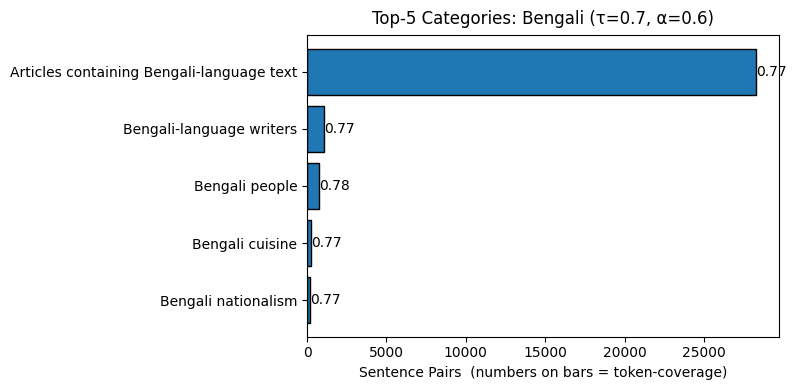

  • saved report_exports/20250505_143850/category_bars_02.png


<Figure size 640x480 with 0 Axes>

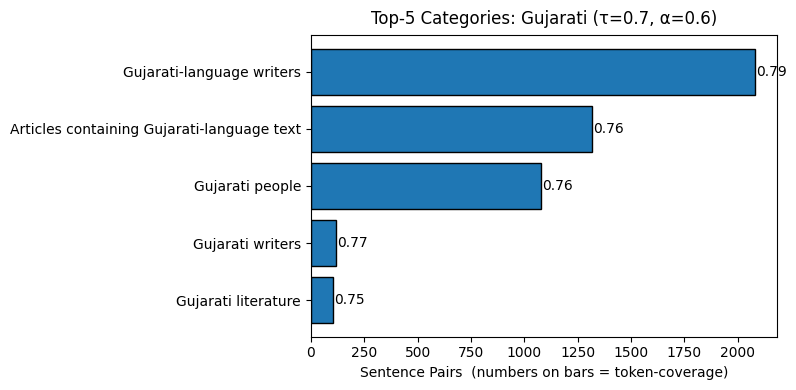

  • saved report_exports/20250505_143850/category_bars_03.png


<Figure size 640x480 with 0 Axes>

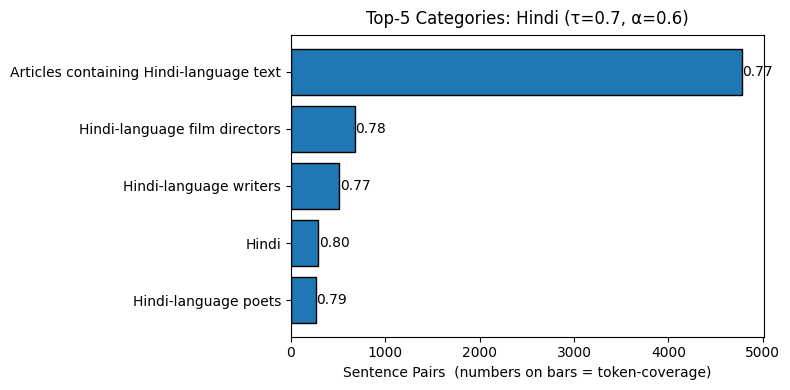

  • saved report_exports/20250505_143850/category_bars_04.png


<Figure size 640x480 with 0 Axes>

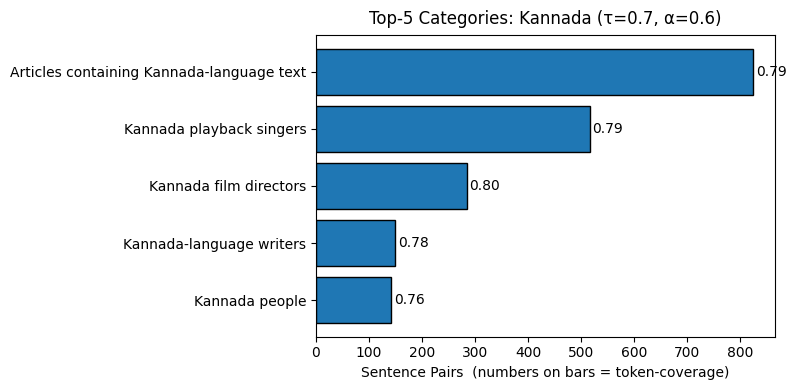

  • saved report_exports/20250505_143850/category_bars_05.png


<Figure size 640x480 with 0 Axes>

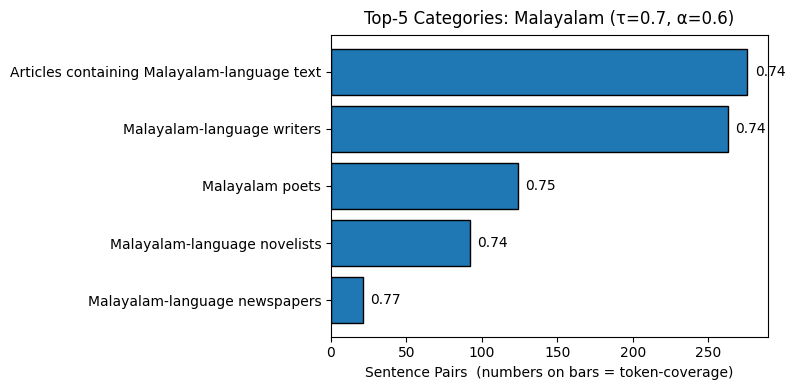

  • saved report_exports/20250505_143850/category_bars_06.png


<Figure size 640x480 with 0 Axes>

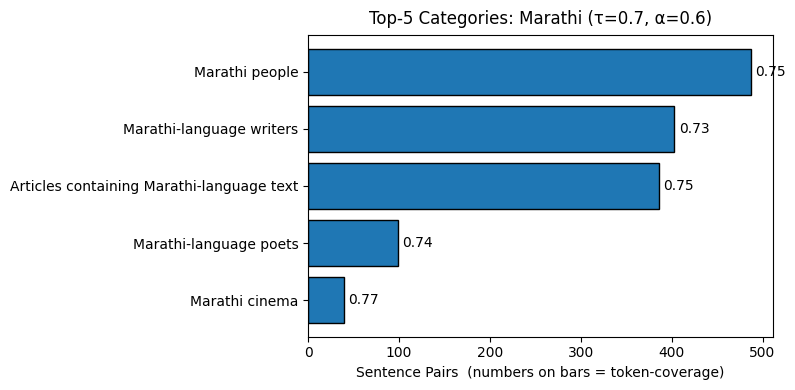

  • saved report_exports/20250505_143850/category_bars_07.png


<Figure size 640x480 with 0 Axes>

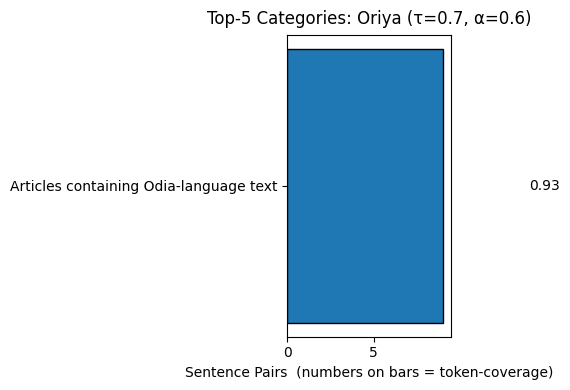

  • saved report_exports/20250505_143850/category_bars_08.png


<Figure size 640x480 with 0 Axes>

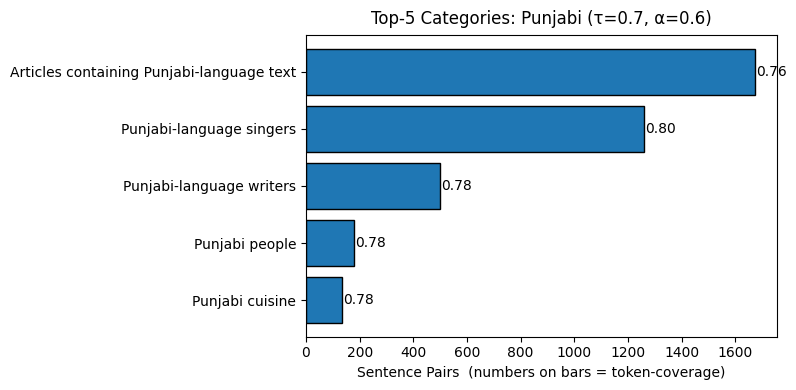

  • saved report_exports/20250505_143850/category_bars_09.png


<Figure size 640x480 with 0 Axes>

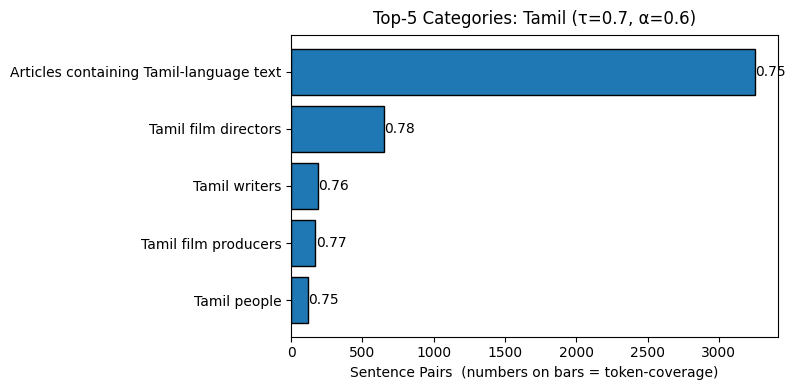

  • saved report_exports/20250505_143850/category_bars_10.png


<Figure size 640x480 with 0 Axes>

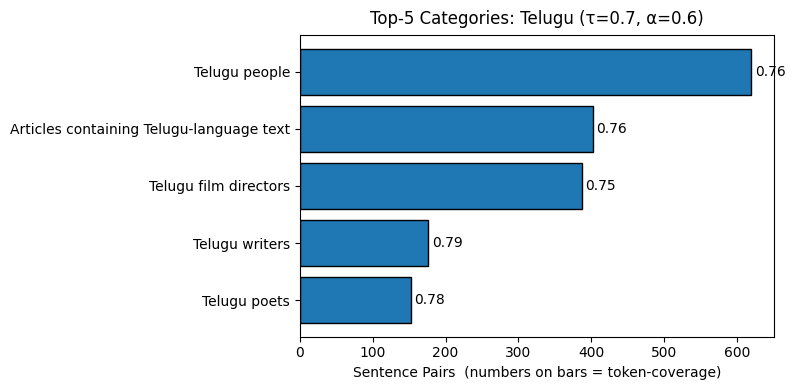

  • saved report_exports/20250505_143850/category_bars_11.png
💾  Multi‑page PDF written to  report_exports/20250505_143850/category_bars.pdf


,Language,Pairs,Mean Cos,Mean Align,En Len,Tgt Len,Len Ratio,Tok Cov
0,Bengali,30951,0.836,0.853,18.7,17.2,1.14,0.77
1,Hindi,6835,0.852,0.808,21.8,22.5,1.13,0.78
2,Gujarati,4932,0.844,0.835,17.3,16.4,1.13,0.77
3,Tamil,4607,0.834,0.843,17.1,15.6,1.15,0.75
4,Punjabi,4059,0.874,0.806,21.3,21.9,1.12,0.78
5,Kannada,2180,0.854,0.899,17.8,15.9,1.16,0.79
6,Telugu,1776,0.831,0.853,16.5,15.0,1.15,0.76
7,Marathi,1497,0.836,0.826,18.6,17.2,1.15,0.75
8,Malayalam,808,0.813,0.835,16.4,14.9,1.16,0.74
9,Assamese,512,0.798,0.748,16.2,15.0,1.14,0.68


ModuleNotFoundError: No module named 'openpyxl'

<Figure size 640x480 with 0 Axes>

In [ ]:
# ------------------------------------------------------------
# 1.  Imports & setup
# ------------------------------------------------------------
import json, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages                # export helper
from datetime import datetime                                       # timestamp

STATS_ROOT = "stats_2"          # ← same prefix you used when writing stats
TAU_GRID   = [0.6, 0.7, 0.8]
ALPHA_GRID = [0.4, 0.5, 0.6, 0.7, 0.8]
LANGS      = ["as","bn","gu","hi","kn","ml","mr","or","pa","ta","te"]
LANG_FULL  = {
    'as':'Assamese','bn':'Bengali','gu':'Gujarati','hi':'Hindi',
    'kn':'Kannada','ml':'Malayalam','mr':'Marathi','or':'Oriya',
    'pa':'Punjabi','ta':'Tamil','te':'Telugu'
}

# ------------------------------------------------------------
# 1‑bis.  Export helpers  (PNG + multi‑page PDF + table files)
# ------------------------------------------------------------
EXPORT_DIR = f"report_exports/{datetime.now():%Y%m%d_%H%M%S}"
os.makedirs(EXPORT_DIR, exist_ok=True)

class FigureCollector:
    """
    Context‑manager that records every Matplotlib figure created *after*
    each plt.show() (or an explicit fig) and:
      • writes a numbered PNG  (stem_01.png, stem_02.png, …)
      • appends the page to a single multi‑page PDF.
    Usage:
        with FigureCollector("sweet_spot") as fc:
            ... plotting code ...
            fc.grab()        # call after each show()
    """
    def __init__(self, stem: str):
        self.stem     = stem
        self._counter = 0
        self._pdf     = None
        self.pdf_path = os.path.join(EXPORT_DIR, f"{stem}.pdf")
        self.png_stem = os.path.join(EXPORT_DIR, stem)

    def __enter__(self):
        self._pdf = PdfPages(self.pdf_path)
        return self

    def grab(self, fig=None, dpi=300):
        fig = fig or plt.gcf()
        self._counter += 1
        png_path = f"{self.png_stem}_{self._counter:02d}.png"
        fig.savefig(png_path, dpi=dpi, bbox_inches="tight")
        self._pdf.savefig(fig, dpi=dpi)
        print(f"  • saved {png_path}")
        return png_path

    def __exit__(self, exc_type, exc_val, exc_tb):
        self._pdf.close()
        print(f"💾  Multi‑page PDF written to  {self.pdf_path}")

def save_table(df: pd.DataFrame, name: str):
    """Save a DataFrame both as CSV and Excel in EXPORT_DIR."""
    csv_path  = os.path.join(EXPORT_DIR, f"{name}.csv")
    xlsx_path = os.path.join(EXPORT_DIR, f"{name}.xlsx")
    df.to_csv(csv_path,  index=False)
    df.to_excel(xlsx_path, index=False)
    print(f"  • table saved →  {csv_path} | {xlsx_path}")

# ------------------------------------------------------------
# 2.  Helper to load one stats file
# ------------------------------------------------------------
def load_stats(lang, tau, alpha):
    fname = f"stats_2_{LANG_FULL[lang].lower()}.json"
    path  = os.path.join(STATS_ROOT, str(tau), str(alpha), fname)
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

# ------------------------------------------------------------
# 3.  Sweet‑spot heat‑map  (colour = mean cosine,
#     cell text = cosine • pairs • len‑ratio)
# ------------------------------------------------------------
with FigureCollector("sweet_spot") as fc:          # start exporting figures
    fig, axes = plt.subplots(4, 3, figsize=(15,20))
    axes = axes.flatten()
    cmap = plt.get_cmap('plasma')

    for idx, lang in enumerate(LANGS):
        grid_cos   = np.zeros((len(ALPHA_GRID), len(TAU_GRID)))
        grid_cnt   = np.zeros_like(grid_cos, dtype=int)
        grid_ratio = np.zeros_like(grid_cos)

        for i, alpha in enumerate(ALPHA_GRID):
            for j, tau in enumerate(TAU_GRID):
                stats = load_stats(lang, tau, alpha)
                if stats:
                    agg = stats["aggregate"]
                    grid_cos[i, j]   = agg["mean_cosine"]
                    grid_cnt[i, j]   = agg["num_pairs"]
                    grid_ratio[i, j] = agg["avg_len_ratio"]
                else:
                    grid_cos[i, j]   = np.nan
                    grid_cnt[i, j]   = 0
                    grid_ratio[i, j] = np.nan

        ax = axes[idx]
        im = ax.imshow(grid_cos, aspect="auto", cmap=cmap, vmin=0.5, vmax=1.0)
        ax.set_xticks(range(len(TAU_GRID)));   ax.set_xticklabels(TAU_GRID, rotation=45)
        ax.set_yticks(range(len(ALPHA_GRID))); ax.set_yticklabels(ALPHA_GRID)
        ax.set_title(LANG_FULL[lang], pad=10)

        for i in range(len(ALPHA_GRID)):
            for j in range(len(TAU_GRID)):
                cos   = grid_cos[i, j]
                cnt   = grid_cnt[i, j]
                ratio = grid_ratio[i, j]
                if np.isnan(cos):
                    txt, clr = "–\n0\n–", "grey"
                else:
                    txt, clr = f"{cos:.2f}\n{cnt}\n{ratio:.2f}", ('white' if cos < 0.75 else 'black')
                ax.text(j, i, txt, ha="center", va="center", fontsize=8, color=clr)

    fig.subplots_adjust(right=0.85, top=0.92)
    cbar_ax = fig.add_axes([0.88,0.15,0.02,0.7])
    fig.colorbar(im, cax=cbar_ax, label='Mean Cosine')
    fig.suptitle("Sweet‑spot Heatmap\n(cell: cosine • sentence‑pairs • len‑ratio)", fontsize=16)
    plt.tight_layout(rect=[0,0,0.85,0.96])
    plt.show()
    fc.grab()                                     # export first figure

# ------------------------------------------------------------
# 4.  Category bar‑chart for τ=0.7, α=0.6
# ------------------------------------------------------------
SAMPLE_TAU, SAMPLE_ALPHA = 0.7, 0.6
with FigureCollector("category_bars") as fc:      # new export context
    for lang in LANGS:
        stats = load_stats(lang, SAMPLE_TAU, SAMPLE_ALPHA)
        if not stats or not stats.get("by_category"):  # skip if no data
            continue
        df_cat = pd.DataFrame.from_dict(stats["by_category"], orient="index")
        df_cat["num_pairs"] = df_cat.get("num_pairs", 0)
        if "avg_token_coverage" not in df_cat.columns:
            df_cat["avg_token_coverage"] = 0.0
        df_cat = df_cat.sort_values("num_pairs", ascending=False).head(5)

        plt.figure(figsize=(8,4))
        bars = plt.barh(df_cat.index[::-1], df_cat["num_pairs"][::-1], edgecolor='k')
        for bar, (_, row) in zip(bars, df_cat[::-1].iterrows()):
            cov = row["avg_token_coverage"]
            plt.text(bar.get_width()+5, bar.get_y()+bar.get_height()/2,
                     f"{cov:.2f}", va='center')
        plt.title(f"Top‑5 Categories: {LANG_FULL[lang]} (τ={SAMPLE_TAU}, α={SAMPLE_ALPHA})", pad=8)
        plt.xlabel("Sentence Pairs  (numbers on bars = token‑coverage)")
        plt.tight_layout()
        plt.show()
        fc.grab()                                 # export each bar chart

# ------------------------------------------------------------
# 5.  Executive table for τ=0.7, α=0.6
# ------------------------------------------------------------
rows = []
for lang in LANGS:
    stats = load_stats(lang, SAMPLE_TAU, SAMPLE_ALPHA)
    if not stats:
        rows.append({"Language": LANG_FULL[lang], "Pairs":0, "Mean Cos":0,
                     "Mean Align":0, "En Len":0, "Tgt Len":0,
                     "Len Ratio":0, "Tok Cov":0})
    else:
        agg = stats["aggregate"]
        rows.append({
            "Language":   LANG_FULL[lang],
            "Pairs":      agg["num_pairs"],
            "Mean Cos":   round(agg["mean_cosine"],3),
            "Mean Align": round(agg["mean_alignment"],3),
            "En Len":     round(agg["avg_en_len"],1),
            "Tgt Len":    round(agg["avg_tgt_len"],1),
            "Len Ratio":  round(agg["avg_len_ratio"],2),
            "Tok Cov":    round(agg["avg_token_coverage"],2)
        })
exec_df = pd.DataFrame(rows).sort_values("Pairs", ascending=False).reset_index(drop=True)
display(exec_df)                                   # notebook‑friendly view
save_table(exec_df, "executive_table_0.7_0.6")     # CSV + XLSX export


In [ ]:
"""
Project English NER tags to Indic sentences
to create a Naamapadam‑style BIO corpus.
"""

import json, os, tqdm
import pandas as pd
import spacy
from simalign import SentenceAligner
from indicnlp.tokenize import sentence_tokenize as stoken
from indicnlp.tokenize import indic_tokenize as itoken   # <-- NEW
from typing import List, Dict

# ----------------------- configurable paths -----------------------
PARALLEL_ROOT = "parallel_datasets_2"          # τ/α folders live here
OUT_ROOT      = "naamapadam_proj"            # output root
# ------------------------------------------------------------------

# spaCy English NER
nlp_en = spacy.load("en_core_web_sm")        # install: python -m spacy download en_core_web_sm
if "sentencizer" not in nlp_en.pipe_names:
    nlp_en.add_pipe("sentencizer", first=True)

# SimAlign
aligner = SentenceAligner(model="bert", token_type="bpe", matching_methods="mai")

LANG_CODE_MAP = {
    'as':'Assamese','bn':'Bengali','gu':'Gujarati','hi':'Hindi','kn':'Kannada',
    'ml':'Malayalam','mr':'Marathi','or':'Oriya','pa':'Punjabi','ta':'Tamil','te':'Telugu'
}

def english_ner(text: str) -> tuple[List[str], List[str]]:
    """Return tokens and BIO tags (spaCy labels mapped to B-/I-)."""
    doc  = nlp_en(text)
    toks = [tok.text for tok in doc]
    tags = ["O"] * len(toks)
    for ent in doc.ents:
        tags[ent.start] = "B-" + ent.label_
        for i in range(ent.start + 1, ent.end):
            tags[i] = "I-" + ent.label_
    return toks, tags

def indic_tokens(sentence: str) -> List[str]:
    return itoken.trivial_tokenize(sentence)

def compute_alignment_score(en_sentence: str, tgt_sentence: str):
    """Return SimAlign 'inter' links list."""
    return aligner.get_word_aligns(en_sentence, tgt_sentence)["inter"]  # <-- fixed call

def project_ner(lang_code: str, tau: float = 0.6, alpha: float = 0.4):
    """Create Naamapadam‑style NER projection for a single (lang, τ, α)."""
    lang_name = LANG_CODE_MAP[lang_code]
    in_path = os.path.join(PARALLEL_ROOT, str(tau), str(alpha),
                           f"parallel_dataset_2_{lang_name.lower()}.json")
    out_dir = os.path.join(OUT_ROOT, str(tau), str(alpha))
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"naamapadam_{lang_name.lower()}.jsonl")

    df = pd.read_json(in_path, lines=True)
    records: List[Dict] = []

    for _, row in tqdm.tqdm(df.iterrows(), total=len(df),
                            desc=f"Projecting > {lang_name}"):
        en_sent  = row["English"]
        tgt_sent = row[lang_name]
        en_toks, en_tags = english_ner(en_sent)
        tgt_toks = indic_tokens(tgt_sent)

        # alignment projection
        inter_links = compute_alignment_score(en_sent, tgt_sent)
        tag_map = {i: tag for i, tag in enumerate(en_tags) if tag != "O"}
        tgt_tags = ["O"] * len(tgt_toks)
        for en_idx, tgt_idx in inter_links:
            if en_idx in tag_map:
                # first occurrence -> B-, subsequent -> I-
                prefix = "B" if tgt_tags[tgt_idx] == "O" else "I"
                tgt_tags[tgt_idx] = prefix + tag_map[en_idx][1:]

        records.append({"tokens": tgt_toks, "ner_tags": tgt_tags})

    with open(out_path, "w", encoding="utf-8") as f:
        for r in records:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

    print(f"Wrote {len(records)} tagged Assamese sentences to {out_path}")

# -------------- example execution ---------------------------------
if __name__ == "__main__":
    project_ner("as", tau=0.6, alpha=0.4)


2025-04-21 13:38:36,048 - simalign.simalign - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased
2025-04-21 13:38:36,048 - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased
Projecting > Assamese: 100%|████████████████| 1437/1437 [12:07<00:00,  1.98it/s]

Wrote 1437 tagged Assamese sentences to naamapadam_proj/0.6/0.4/naamapadam_assamese.jsonl
